In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imread
from skimage.transform import resize

# Load and preprocess image

In [2]:
img_url = "https://upload.wikimedia.org/wikipedia/commons/5/50/Vd-Orig.png"
image_path = tf.keras.utils.get_file("color_target.jpg", origin=img_url)
rgb = imread(image_path) / 255.0                                  # Load and normalize image
rgb = resize(rgb, (128, 128))                                     # Resize image
lab = rgb2lab(rgb)                                                # Convert to LAB color space
 
X_l = lab[..., 0:1] / 100.0                                       # Normalize L channel to [0, 1]
y_ab = lab[..., 1:] / 128.0                                       # Normalize ab channels to [-1, 1]
 
X_l = X_l[np.newaxis, ...]                                        # Add batch dimension
y_ab = y_ab[np.newaxis, ...]

20853/20853 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step


# Define simplified U-Net model

In [3]:
inputs = tf.keras.Input(shape=(128, 128, 1))
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D()(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
outputs = tf.keras.layers.Conv2D(2, 3, activation='tanh', padding='same')(x)  # Predict ab channels
 
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')

# Train on single image (demo only)

In [4]:
model.fit(X_l, y_ab, epochs=100, verbose=0)

# Predict ab channels and reconstruct LAB image

In [5]:
pred_ab = model.predict(X_l)[0]
lab_output = np.concatenate([X_l[0], pred_ab * 128.0], axis=-1)   # Denormalize ab and combine
rgb_out = lab2rgb(lab_output)                                     # Convert LAB back to RGB

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


# Plot input and output

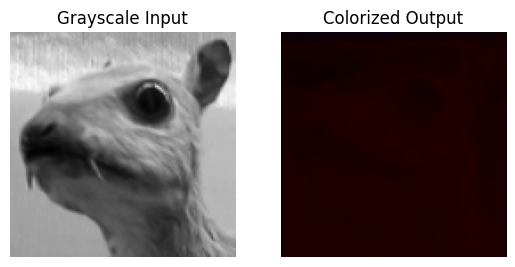

In [6]:
plt.subplot(1, 2, 1)
plt.imshow(X_l[0].squeeze(), cmap='gray')
plt.title("Grayscale Input")
plt.axis('off')
 
plt.subplot(1, 2, 2)
plt.imshow(rgb_out)
plt.title("Colorized Output")
plt.axis('off')
plt.show()